### Continuous time RNNs (5 points)

Recreate the phase portrait for the CTRNN shown in the lecture slides. NOTE: You do not need to visualize the vector field.

In [1]:
import matplotlib.pyplot as plt
import numpy as np

Text(0, 0.5, 'Neuron 2')

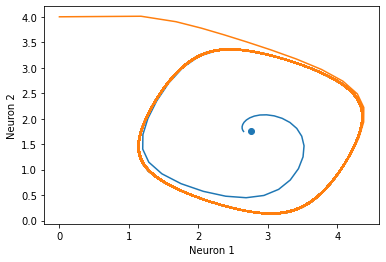

In [128]:
w_11 = w_22 = 4.5
w_12 = -1
w_21 = 1
W = np.array([[w_11, w_12],
              [w_21, w_22]]).T

b = np.array([-2.75, -1.75]).T

dt = 1.0
time_steps = 10000

ys = [0, 4]
bs = [2.5, 2.5]

aa = np.zeros(shape=(time_steps, 2))
aa[0, 0] = 0
aa[0, 1] = 4
bb = np.zeros(shape=(time_steps, 2))
bb[0, 0] = 2.65
bb[0, 1] = 1.75

sigmoid = lambda x : 1 / (1 + np.exp(-x))

for i in range(1, time_steps):
    
    aa[i] = W@sigmoid(aa[i-1,:] + b) 
    bb[i] = W@sigmoid(bb[i-1,:] + b)
    

plt.figure(1)
plt.scatter(-b[0], -b[1])
plt.plot(bb[:,0], bb[:, 1])
plt.plot(aa[:,0], aa[:, 1])


plt.xlabel("Neuron 1")
plt.ylabel("Neuron 2")

### Backpropagation through time (5 points)

Implement the backward pass of the BPTT algorithm. The rest of the code is given and will lead to an RNN which learns to solve the copy task.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
import time
import sys

$$
e_t = V^{T}_{t}(y_t - t_t) + W^{T}_{t}\delta_{t+1}
$$

$$
\delta_t = e_t \circ d_t
$$

In [6]:

"""
Define very basic RNN which copies the state of the input r timesteps ago

"""

np.random.seed(0)

def sigmoid(x):
    return 1.0 / (1 + np.exp(-x))

def sigmoid_derivative(x):
    return sigmoid(x) * (1.0 - sigmoid(x))

def grad_clip(grad, clip=None):
    if clip is None:
        return grad
    elif not np.any(grad):
        return grad
    else:
        return clip * grad / np.linalg.norm(grad.flatten())

n_epochs = 200      # number of epochs
batch_size = 20     # number of examples to process in each batch
n_time = 30         # number of time points
eta = 10**-3        # learning rate
sigma = 10**-1      # initialization constant (standard deviation of the normal distribution)
N = 5               # number of hidden units
M = K = 1           # number of inputs and outputs (must be same as output for copy task)
r = 1               # distance between input and output on copy task (e.g. r=1 is a delay of one timestep)
clip = 50.0         # gradient clipping

W = sigma * np.random.randn(N, N) # recurrent weight matrix
b = sigma * np.random.randn(N)    # bias terms
U = sigma * np.random.randn(N, M) # input weight matrix
# V : weights between hidden and output layers
V = sigma * np.random.randn(K, N) # tangents/adjoints ???
print("V", V.shape)
print("U", U.shape)

tic = time.perf_counter()

loss = np.zeros(n_epochs)
for e in tqdm(range(n_epochs)):  # epochs

    DeltaW = np.zeros([N, N]) # (5, 5)
    DeltaU = np.zeros([N, M]) # (5, 1)
    DeltaV = np.zeros([K, N]) # (1, 5)
    Deltab = np.zeros(N)      # (5,)

    for _ in range(batch_size):

        x = np.random.randn(n_time, M) # driving input
        # target data - x data translated along x-axis by r
        target = np.vstack([np.zeros([r, K]), x[:-r]])

        a = np.zeros([n_time, N]) # internal state of neurons
        ell = np.zeros([n_time, M])
        h = np.zeros([n_time, N]) # externally observable state (output)
        y = np.zeros([n_time, K]) 
        bary = np.zeros([n_time, K])

        # forward pass
        for t in range(n_time):

            a[t] = U @ x[t] + b
            if t > 0: # captures weights of previous timesteps in RNN 
                a[t] += W @ h[t-1]
            h[t] = sigmoid(a[t])
            y[t] = V @ h[t]
            bary[t] = (y[t] - target[t])
            ell[t] = 0.5 * np.linalg.norm(bary[t])**2

        e_t = np.zeros(N)
        d_t = np.zeros(N)
        
        # backward pass
        bara = np.zeros([n_time + 1, N])
        for t in range(n_time-1, -1, -1):

            ### COMPUTE THE PARAMETER UPDATES HERE ### 
            e_t = np.dot(V.T, bary[t,:]) + np.dot(W.T, bara[t+1,:])
            
            d_t = sigmoid_derivative(a[t])
            bara[t,:] = np.multiply(e_t, d_t)
            
#             DeltaW += -1 * ( np.multiply(e_t, sigmoid_derivative(a[t])) @ h[t].T )            
#             DeltaU += -1 * np.reshape(np.multiply(np.multiply( e_t, d_t ), x[t].T), (5,1))
#             DeltaV += -1 * np.multiply( bary[t], h[t].T )
#             Deltab += -1 * np.multiply(np.multiply( e_t, d_t ), (1 - 0) )
            DeltaW += -1 * np.outer(bara[t,:], h[t-1])
            DeltaU += -1 * np.outer(bara[t,:], x[t].T)
            DeltaV += -1 * np.outer(bary[t,:].T, h[t].T)
            Deltab += -1 * bara[t,:]

        loss[e] += np.sum(ell)

    V += eta * grad_clip(DeltaV, clip=clip)
    W += eta * grad_clip(DeltaW, clip=clip)
    U += eta * grad_clip(DeltaU, clip=clip)
    b += eta * grad_clip(Deltab, clip=clip)


toc = time.perf_counter()

print(f"time elapsed: {toc - tic:0.4f} seconds")
print('loss : ' + str(loss[-1]))

  1%|▊                                                                                 | 2/200 [00:00<00:11, 17.59it/s]

V (1, 5)
U (5, 1)


100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [00:15<00:00, 12.77it/s]

time elapsed: 15.6704 seconds
loss : 15.60949474532357


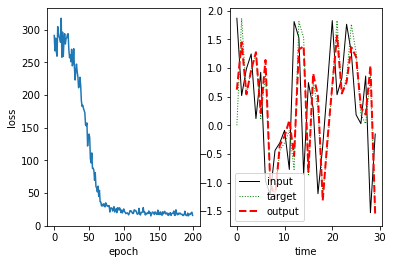

In [7]:
# plot results

plt.subplot(1,2,1)
plt.plot(loss)
plt.xlabel('epoch')
plt.ylabel('loss')

plt.subplot(1,2,2)
plt.plot(x[:, 0], color='black', linestyle='solid', linewidth=1, label='input')
plt.plot(target[:,0], color='green', linestyle=':', linewidth=1, label='target')
plt.plot(y[:,0], color='red', linestyle='--', linewidth=2,label='output')
plt.xlabel('time')
plt.legend()

plt.show()